# Test for GPU

In [1]:
!nvidia-smi

Wed Jul 20 22:06:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8     4W /  N/A |      5MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Get Training Data

In [ ]:
def get_file(filename, url):
    """
    get file with wget from url if the file does not exist
    """
    COMMAND = f"""if [ -f {filename} ];
    then
        echo '{filename} already exists.';
    else
        wget '{url}';
    fi"""
    ! eval "{COMMAND}"

url_prefix = "https://github.com/ntueecamp/22-software-workshop/releases/download/v1.0.0/"

file_names = [
    "training_spectrogram.npz.xaa",
    "training_spectrogram.npz.xab",
    "training_spectrogram.npz.xac",
    "validation_spectrogram.npz",
    "test_spectrogram.npz"
]

for f in file_names:
    get_file(f, url_prefix+f)

! if [ -f training_spectrogram.npz ]; \
then \
    echo "training_spectrogram.npz already exists."; \
else \
    cat training_spectrogram.npz.xa* > training_spectrogram.npz; \
    echo "done merging files"; \
fi

# Training

This treats the spectrograms of the words like images

In [2]:
# Import all the things we will need
import datetime
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.data import Dataset
import matplotlib.pyplot as plt
import gc

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-07-20 22:06:47.367250: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-20 22:06:47.403465: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-20 22:06:47.403975: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
# List of the words in categorical order
command_words = (
    'forward',
    'backward',
    'left',
    'right',
    '_invalid',
)

In [5]:
# Load up the sprectrograms and labels
training_spectrogram = np.load('training_spectrogram.npz')
validation_spectrogram = np.load('validation_spectrogram.npz')
test_spectrogram = np.load('test_spectrogram.npz')

(array([27825., 30625., 18760., 21110., 64592.]),
 array([0, 1, 2, 3, 4, 5]),
 <BarContainer object of 5 artists>)

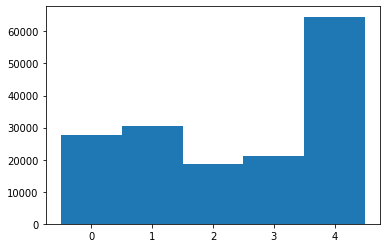

In [7]:
# plot a distribution of the words
plt.hist(training_spectrogram['Y'], bins=range(0,len(command_words)+1), align='left')

In [8]:
unique, counts = np.unique(training_spectrogram['Y'], return_counts=True)
print(unique, counts)
dict(zip([command_words[i] for i in unique], counts))

[0 1 2 3 4] [27825 30625 18760 21110 64592]


{'forward': 27825,
 'backward': 30625,
 'left': 18760,
 'right': 21110,
 '_invalid': 64592}

In [9]:
# extract the data from the files
X_train = training_spectrogram['X']
X_validate = validation_spectrogram['X']
Y_train = tf.one_hot(training_spectrogram['Y'], len(command_words))
Y_validate = tf.one_hot(validation_spectrogram['Y'], len(command_words))

# get the width and height of the spectrogram "image"
IMG_WIDTH=X_train[0].shape[0]
IMG_HEIGHT=X_train[0].shape[1]

train_size = len(X_train)

2022-07-20 22:07:29.178123: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-20 22:07:29.179922: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-20 22:07:29.180366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-20 22:07:29.180765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [10]:
# create the datasets for training
batch_size = 32

train_dataset = Dataset.from_tensor_slices(
    (X_train, Y_train)
).repeat(
    count=-1
).shuffle(
    train_size
).batch(
    batch_size
)

validation_dataset = Dataset.from_tensor_slices((X_validate, Y_validate)).batch(X_validate.shape[0]//10)

2022-07-20 22:07:33.630349: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2774065536 exceeds 10% of free system memory.
2022-07-20 22:07:34.944129: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2774065536 exceeds 10% of free system memory.
2022-07-20 22:07:35.762812: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 346128156 exceeds 10% of free system memory.
2022-07-20 22:07:35.947070: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 346128156 exceeds 10% of free system memory.


In [11]:
del X_train
del X_validate
del Y_train
del Y_validate

gc.collect()

10

In [12]:
model = Sequential([
    Conv2D(4, 3, 
           padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(0.001),
           name='conv_layer1',
           input_shape=(IMG_WIDTH, IMG_HEIGHT, 1)),
    MaxPooling2D(name='max_pooling1', pool_size=(2,2)),
    Conv2D(4, 3, 
           padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(0.001),
           name='conv_layer2'),
    MaxPooling2D(name='max_pooling3', pool_size=(2,2)),
    Flatten(),
    Dropout(0.1),
    Dense(
        80,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        name='hidden_layer1'
    ),
    Dropout(0.1),
    Dense(
        len(command_words), 
        activation='softmax',
        kernel_regularizer=regularizers.l2(0.001),
        name='output'
    )
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_layer1 (Conv2D)        (None, 99, 43, 4)         40        
                                                                 
 max_pooling1 (MaxPooling2D)  (None, 49, 21, 4)        0         
                                                                 
 conv_layer2 (Conv2D)        (None, 49, 21, 4)         148       
                                                                 
 max_pooling3 (MaxPooling2D)  (None, 24, 10, 4)        0         
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 hidden_layer1 (Dense)       (None, 80)                7

In [14]:
epochs=5

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Logging to tensorboard
We log the training stats along with the confusion matrix of the test data - should we be using the validation data

# Train model

In [15]:
model.fit(
    train_dataset,
    steps_per_epoch=train_size // batch_size,
    epochs=epochs,
    validation_data=validation_dataset,
    validation_steps=10,
)

2022-07-20 22:08:14.004490: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2774065536 exceeds 10% of free system memory.


Epoch 1/5


2022-07-20 22:08:17.618140: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-07-20 22:08:18.732673: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-20 22:08:18.734564: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-20 22:08:18.734624: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-07-20 22:08:18.736466: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-20 22:08:18.736604: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


5091/5091 [==============================] - 34s 6ms/step - loss: 0.6275 - accuracy: 0.8049 - val_loss: 0.4236 - val_accuracy: 0.8908
Epoch 2/5
5091/5091 [==============================] - 29s 6ms/step - loss: 0.4286 - accuracy: 0.8872 - val_loss: 0.3871 - val_accuracy: 0.9094
Epoch 3/5
5091/5091 [==============================] - 28s 6ms/step - loss: 0.4016 - accuracy: 0.8973 - val_loss: 0.3674 - val_accuracy: 0.9153
Epoch 4/5
5091/5091 [==============================] - 28s 6ms/step - loss: 0.3903 - accuracy: 0.9011 - val_loss: 0.3704 - val_accuracy: 0.9151
Epoch 5/5
5091/5091 [==============================] - 28s 6ms/step - loss: 0.3831 - accuracy: 0.9049 - val_loss: 0.3600 - val_accuracy: 0.9129


In [16]:
model.save("trained.model")

INFO:tensorflow:Assets written to: trained.model/assets


INFO:tensorflow:Assets written to: trained.model/assets


# Testing the Model

In [17]:
X_test = test_spectrogram['X']
Y_test = tf.one_hot(test_spectrogram['Y'], len(command_words))

test_dataset = Dataset.from_tensor_slices((X_test, Y_test)).batch(len(X_test))

In [18]:
results = model.evaluate(X_test, tf.cast(Y_test, tf.float32), batch_size=128)

160/160 [==============================] - 1s 4ms/step - loss: 0.3891 - accuracy: 0.9034


In [19]:
predictions = model.predict(X_test, 128)

160/160 [==============================] - 1s 3ms/step


In [20]:
import itertools


def plot_confusion_matrix(cm, class_names):
    """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
    cm = cm.numpy()
    # Normalize the confusion matrix.[c]rea
    cm = np.around(cm.astype("float") / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
#     return figure

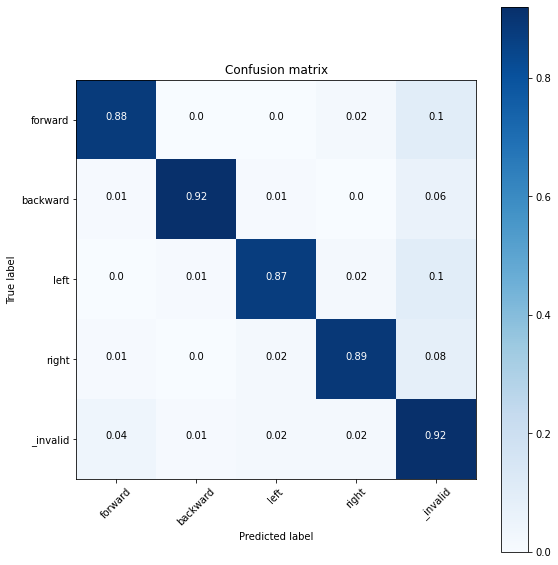

In [21]:
cm = tf.math.confusion_matrix(
    labels=tf.argmax(Y_test, 1), predictions=tf.argmax(predictions, 1)
)

plot_confusion_matrix(cm, command_words)

# Save the model to local


In [22]:
!zip -r trained_model.zip trained.model 

  adding: trained.model/ (stored 0%)
  adding: trained.model/assets/ (stored 0%)
  adding: trained.model/saved_model.pb (deflated 90%)
  adding: trained.model/variables/ (stored 0%)
  adding: trained.model/variables/variables.index (deflated 65%)
  adding: trained.model/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: trained.model/keras_metadata.pb (deflated 90%)


In [23]:
validation_spectrogram = np.load('validation_spectrogram.npz')
X_validate = validation_spectrogram['X']

converter2 = tf.lite.TFLiteConverter.from_saved_model("trained.model")
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
def representative_dataset_gen():
    for i in range(0, len(X_validate), 100):
        # Get sample input data as a numpy array in a method of your choosing.
        yield [X_validate[i:i+100]]
converter2.representative_dataset = representative_dataset_gen
converter2.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_quant_model = converter2.convert()
open("converted_model.tflite", "wb").write(tflite_quant_model)

2022-07-20 22:15:08.908792: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-07-20 22:15:08.908823: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-07-20 22:15:08.910114: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: trained.model
2022-07-20 22:15:08.912813: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-07-20 22:15:08.912839: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: trained.model
2022-07-20 22:15:08.918149: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-07-20 22:15:08.920520: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-07-20 22:15:08.970051: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: trained.model
2022-07-20 22:15

82248

In [24]:
!xxd -i converted_model.tflite > model_data.cc